## imports

In [1]:
import trackpy as tp
import pims
from skimage import color
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

%matplotlib inline

This is entirely using `http://soft-matter.github.io/trackpy/v0.5.0/tutorial/walkthrough.html`

In [3]:
# change this to your data path!

path = 'debug_data/video-1/video-1/*.bmp'

frames = pims.as_grey(pims.open(path))

# find particles as a batch

Here we use the `trackpy`'s `batch` function to find particles in a batch. You can tune all the parameters of this function, shown below:

In [6]:
print(tp.batch.__doc__)

Locate Gaussian-like blobs of some approximate size in a set of images.

    Preprocess the image by performing a band pass and a threshold.
    Locate all peaks of brightness, characterize the neighborhoods of the peaks
    and take only those with given total brightness ("mass"). Finally,
    refine the positions of each peak.

    Parameters
    ----------
    frames : list (or iterable) of images
        The frames to process.
    diameter : odd integer or tuple of odd integers
        This may be a single number or a tuple giving the feature's
        extent in each dimension, useful when the dimensions do not have
        equal resolution (e.g. confocal microscopy). The tuple order is the
        same as the image shape, conventionally (z, y, x) or (y, x). The
        number(s) must be odd integers. When in doubt, round up.
    output : {None, trackpy.PandasHDFStore, SomeCustomClass}
        If None, return all results as one big DataFrame. Otherwise, pass
        results from ea

In [7]:
loc = tp.batch(frames, diameter=11, minmass=100, separation=2)

Frame 3881: 33 features


## track linking

next, we link trajectories based on found particles. Again, this function has a lot of tunable parameters which I will not go into here, but see the docstring if you need!

In [8]:
link = tp.link(loc, 5, memory=10)

Frame 3881: 33 trajectories present.


## drift/filtering

here we compute the drift (we can subtract it if we want too) and filter stubs out. We can also see how to use the `annotate` function, which draws circles around found particles.

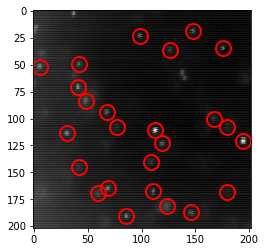

<AxesSubplot:>

In [9]:
drift = tp.compute_drift(link)
# link = tp.subtract_drift(link, drift=drift)
link = tp.filter_stubs(link)

i = 100
tp.annotate(link[link.frame==i], frames[i])

## trajectory visualization

we can plot the trajectories using the `plot_traj` helper function, and see that many are pretty good.

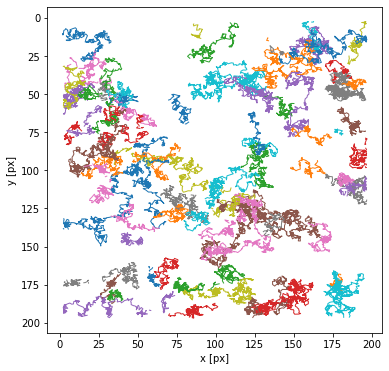

In [12]:
fig,ax = plt.subplots(figsize=(6,6))
tp.plot_traj(link[link.frame < 1000])
ax.set_aspect('equal')

## now we can plot the mean squared dispersion!

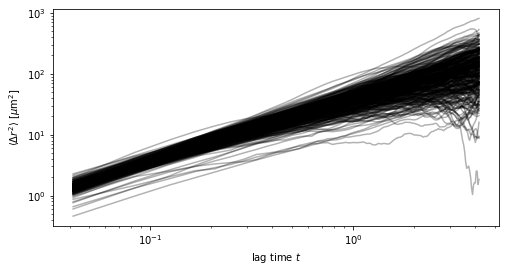

In [13]:
microns_per_pixel = 1
frames_per_second = 24

mean_square_disp = tp.imsd(link, microns_per_pixel, frames_per_second)
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(mean_square_disp.index, mean_square_disp, 'k-', alpha=.3)
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_yscale('log')
ax.set_xscale('log')

## and the fit to time dispersion 

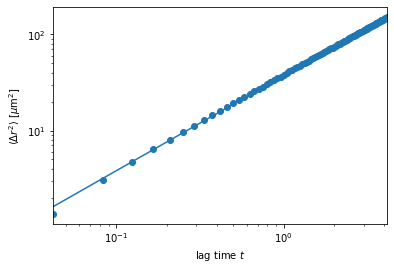

,n,A
msd,0.991785,37.406395


In [14]:
em = tp.emsd(link, microns_per_pixel, frames_per_second)

fig, ax = plt.subplots()
# ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')

tp.utils.fit_powerlaw(em) 


## dispersion constant

detailed calculations for the dispersion constant can be found on the trackpy website, or with googling. (this is the part you do yourself :-))